In [2]:
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate

import kagglehub

from constants import dataset_name, opciones, CV, scoring
from utils import cargar_imagenes, evaluar_rendimiento, save_excel_cv

from modelos.RegresionLogistica import regresion_logistica
from modelos.CNN import cnn1, cnn2
from modelos.KNN import knn, knn_with_gridsearch
from modelos.ArbolDeDecision import arbol_decision, arbol_decision_vgg16, arbol_vgg16_pca
from modelos.MobileNetV2 import train_mobilenetv2_model
from modelos.RandomForest import random_forest, rforest_vgg16_pca, rforest_vgg16_pca_hog
from Extractores_con_clasificador.hog_main import main_hog, extract_hog_features
from Extractores_con_clasificador.ann_hog import ann_hog
from Extractores_con_clasificador.svm_hog import svm_hog
from tensorflow.keras.utils import to_categorical
from modelos.MobileNetV2 import train_mobilenetv2_model

import matplotlib.pyplot as plt


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Descargar dataset
path = kagglehub.dataset_download(dataset_name)

# cargar train y test
X_train_rgb, y_train = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), channel_mode="rgb")
X_test_rgb, y_test = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), channel_mode="rgb")
X_train_gray, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), channel_mode="grayscale")
X_test_gray, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), channel_mode="grayscale")
X_train_rgb_64, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), target_size=(64, 64))
X_test_rgb_64, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), target_size=(64, 64))

# Codificar etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

epochs = 100
batch_size = 100
history = []


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

def regresion_logistica(X_train, y_train_encoded):
    # Aplanar las imágenes de 4D a 2D
    X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Aplanar a 2D: [n_samples, n_features]
    # Entrenar modelo de Regresión Logística
    modelLR = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000)

    # Validación cruzada
    scoresLR = cross_validate(modelLR, X_train_flat, y_train_encoded, cv=CV, scoring=scoring)

    # Entren
    modelLR.fit(X_train_flat, y_train_encoded)

    return modelLR, scoresLR
modelLR_rgb, scoresLR_rgb = regresion_logistica(X_train_rgb, y_train_encoded)
scoresLR_rgb

{'fit_time': array([289.57328486, 266.15953302, 255.05790281, 296.18507695,
        284.28474689]),
 'score_time': array([3.86180425, 1.18869185, 5.69349504, 3.61447334, 2.971771  ]),
 'test_accuracy': array([0.35875706, 0.40112994, 0.38418079, 0.3799435 , 0.36723164]),
 'test_precision': array([0.36038192, 0.4059596 , 0.38064603, 0.37367103, 0.36692714]),
 'test_recall': array([0.35040466, 0.39087756, 0.37756921, 0.36905543, 0.36243575]),
 'test_f1': array([0.35196512, 0.39245194, 0.37662943, 0.36871569, 0.36305818]),
 'test_roc_auc': array([0.66982569, 0.69771998, 0.67740787, 0.6804598 , 0.67023869])}

In [ ]:
save_excel_cv(scoresLR_rgb, "Regresión Logística RGB")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA

from utils import plot_rendimiento
## evaluar rendimiento ##
def evaluar_rendimiento(model, X_test, y_test, nombre_metodo, pca):
    # Aplanar las imágenes de prueba
    X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Aplanar a 2D: [n_samples, n_features]
        
    # Hacer predicciones
    y_pred = model.predict(X_test_flat)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    # ROC y AUC
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.arange(0, n_classes, 1))
    y_score = model.predict_proba(X_test_flat)

    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # ROC por clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plot_rendimiento(
        cm,
        model.classes_,
        fpr_micro,
        tpr_micro,
        roc_auc_micro,
        fpr,
        tpr,
        roc_auc
    )





[1 2 1 2 3 3 0 2 0 2 3 4 2 3 3 4 3 0 3 4 0 1 0 2 0 1 0 1 3 1 4 2 1 0 4 1 2
 1 0 0 4 0 2 2 4 1 4 2 4 0]


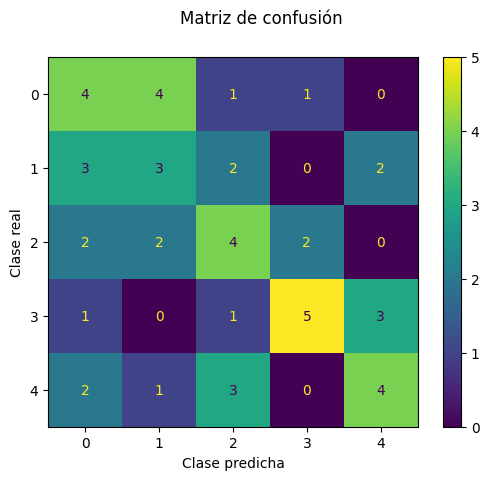

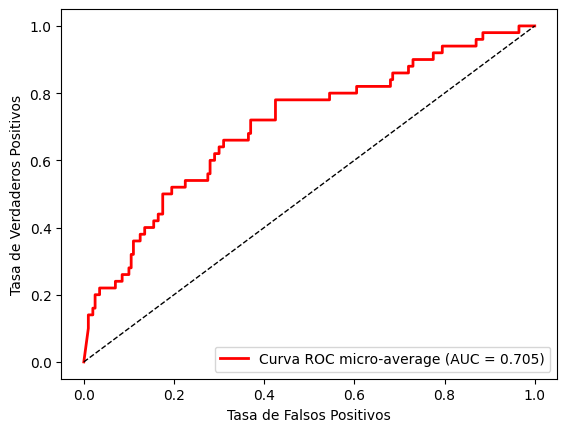

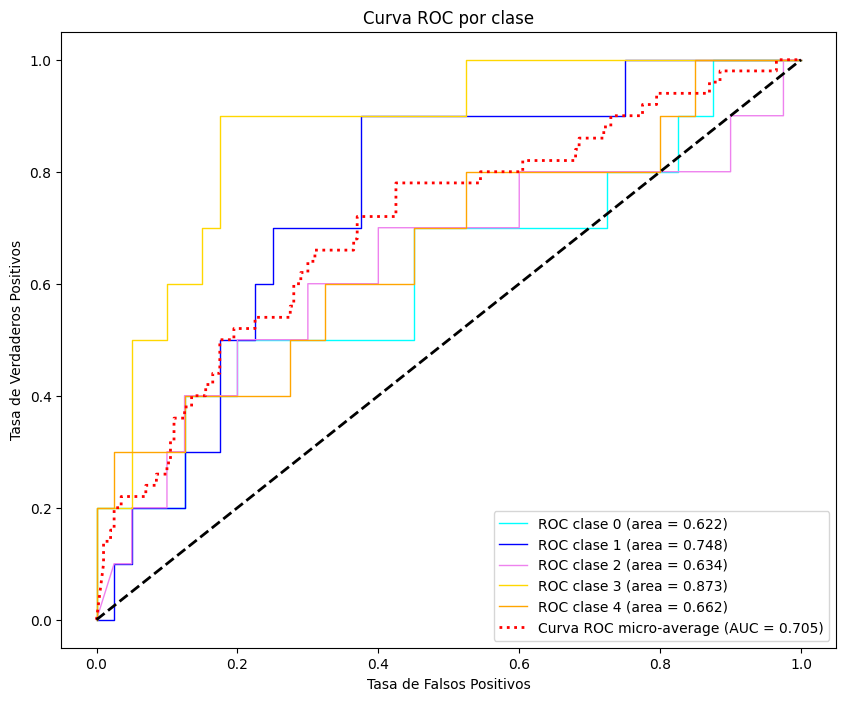

In [63]:
evaluar_rendimiento(modelLR_rgb, X_test_rgb, y_test_encoded, "Regresión Logística RGB", None)

In [9]:
scoresCNN2 = {'test_precision': [0.7166738248553859, 0.7041283818414615, 0.6720787774319513, 0.6921503919537386, 0.7045955135686659, 0.820073856540952, 0.7959790114197542, 0.7712867208802812, 0.7844094707793677, 0.787384015298203],
'test_recall_macro': [0.711597019549149, 0.6762706917034151, 0.6687601520624888, 0.6907504756048505, 0.6969254875957323, 0.7995981124227757, 0.7960855801647762, 0.7704563414982138, 0.7893387202581493, 0.757117470457348],
'precision_micro': [0.7189265536723164, 0.6892655367231638, 0.6751412429378532, 0.6892655367231638, 0.7005649717514124, 0.809322033898305, 0.7923728813559322, 0.768361581920904, 0.7754237288135594, 0.7669491525423728],
'test_recall': [0.7189265536723164, 0.6892655367231638, 0.6751412429378532, 0.6892655367231638, 0.7005649717514124, 0.809322033898305, 0.7923728813559322, 0.768361581920904, 0.7754237288135594, 0.7669491525423728],
'test_f1': [0.7095901984100481, 0.6801325554343552, 0.66757243032618, 0.6874430324110129, 0.6973471041516788, 0.8055658063854786, 0.7901395273737473, 0.7647168047760065, 0.7768680102404468, 0.7657856548824592],
'test_accuracy': [0.7189265536723164, 0.6892655367231638, 0.6751412429378532, 0.6892655367231638, 0.7005649717514124, 0.809322033898305, 0.7923728813559322, 0.768361581920904, 0.7754237288135594, 0.7669491525423728],
'test_roc_auc': [np.float64(0.9282246641628547), np.float64(0.9162007813105575), np.float64(0.9118607883397637), np.float64(0.9134545308807575), np.float64(0.9200880650727971), np.float64(0.9659379739630877), np.float64(0.9563853505318669), np.float64(0.9487675943677406), np.float64(0.9552110614532022), np.float64(0.9532319060265841)]}

save_excel_cv(scoresCNN2, "CNN2") 

In [21]:
scores_RF_VGG_PCA_HOG = {'fit_time': [57.03687286, 57.75530291, 58.63800883, 57.5058589 , 57.21213508], 
                         'score_time': [0.18205428, 0.19486666, 0.21000838, 0.17675304, 0.18600368], 
                         'test_accuracy': [0.47175141, 0.50847458, 0.48728814, 0.5       , 0.50282486], 
                         'test_precision': [0.48036714, 0.51298292, 0.49314922, 0.5192612 , 0.51314899], 
                         'test_recall': [0.45286691, 0.49203195, 0.46949149, 0.48030549, 0.48352989], 
                         'test_f1': [0.45306809, 0.49380836, 0.47097024, 0.4810936 , 0.48378187], 
                         'test_roc_auc': [0.7575709 , 0.77457836, 0.77561203, 0.77389724, 0.7855328 ]}
save_excel_cv(scores_RF_VGG_PCA_HOG, "Random forest VGG16 PCA HOG")

In [68]:
SCORES_RF_HOG_n_components_250 = {'fit_time': [55.40866017, 54.39986444, 55.02342534, 55.53264856, 55.02032781], 
 'score_time': [0.55024147, 0.24055052, 0.49388266, 0.47563815, 0.24083543], 
 'test_accuracy': [0.45621469, 0.51553672, 0.50423729, 0.48446328, 0.50847458], 
 'test_precision': [0.47010577, 0.52946164, 0.50570362, 0.49165395, 0.52378514], 
 'test_recall': [0.43873715, 0.49804412, 0.48377195, 0.46209981, 0.48565412], 
 'test_f1': [0.44073649, 0.50149196, 0.48315199, 0.45908465, 0.48401781], 
 'test_roc_auc': [0.7603715 , 0.77271304, 0.77732069, 0.7731589 , 0.79332211]}
 
scores_RF_VGG16_n_components_250 = {'fit_time': [13.01640654, 13.08210397, 13.12833428, 13.00343013, 13.17719555],
  'score_time': [0.38450766, 0.08999133, 0.35077596, 0.35202217, 0.37078118],
  'test_accuracy': [0.60734463, 0.61440678, 0.61158192, 0.59887006, 0.61158192],
  'test_precision': [0.63844188, 0.63861038, 0.64318678, 0.63330433, 0.65672759],
  'test_recall': [0.58736968, 0.59717177, 0.59285152, 0.57793441, 0.58849631],
  'test_f1': [0.59419786, 0.60365032, 0.59990574, 0.58287372, 0.5963383 ],
  'test_roc_auc': [0.86093233, 0.85161286, 0.85432804, 0.8500331 , 0.86767739]}

save_excel_cv(SCORES_RF_HOG_n_components_250, "Random forest HOG 250")
save_excel_cv(scores_RF_VGG16_n_components_250, "Random forest VGG16 250")

In [20]:
scores_arbol_VGG = {'fit_time': [2.92314553, 2.79935145, 2.73940516, 2.72962141, 3.13327861], 
 'score_time': [0.01353049, 0.01208973, 0.0129962 , 0.01604486, 0.01669478],
   'test_accuracy': [0.45762712, 0.46327684, 0.45621469, 0.45480226, 0.47175141], 
   'test_precision': [0.45753203, 0.46106483, 0.45660949, 0.45518212, 0.46020465]
   , 'test_recall': [0.4484089 , 0.45764843, 0.4502945 , 0.44352499, 0.45596342],
     'test_f1': [0.44756566, 0.45650768, 0.45091984, 0.44456435, 0.45597603], 
     'test_roc_auc': [0.68809414, 0.69802387, 0.6701636 , 0.68289768, 0.69160653]}
save_excel_cv(scores_arbol_VGG, "Arbol de decisión VGG16")

In [19]:
scores_arbol_VGG_PCA = {'fit_time': [2.0969615 , 2.09246373, 2.24219704, 2.21344399, 2.15724707], 
                        'score_time': [0.01099706, 0.00998712, 0.01115298, 0.01300621, 0.00999522],
                        'test_accuracy': [0.38559322, 0.41384181, 0.40112994, 0.42231638, 0.47175141], 
                        'test_precision': [0.38396418, 0.40914838, 0.39453507, 0.41153651, 0.461122  ],
                        'test_recall': [0.38392835, 0.41108042, 0.39469703, 0.41286745, 0.46034558], 
                        'test_f1': [0.38297892, 0.40828347, 0.39427767, 0.41137591, 0.45996553], 
                        'test_roc_auc': [0.61478894, 0.63208578, 0.62228752, 0.63406091, 0.66379507]}
save_excel_cv(scores_arbol_VGG_PCA, "Arbol de decisión VGG16 PCA")

accuracy
Regresión Logística gray       0.245480
Arbol de decisión VGG16 PCA    0.418927
Arbol de decisión VGG16        0.460734
Random forest VGG16 PCA HOG    0.494068
Regresión Logística RGB        0.378249
CNN1                           0.685937
KNN                            0.416206
RANDOM FOREST                  0.539831
Random Forest VGG16            0.713277
MobileNetV2                    0.860000
Regresión Logística gray       0.267797
CNN2                           0.738559
Name: accuracy, dtype: float64


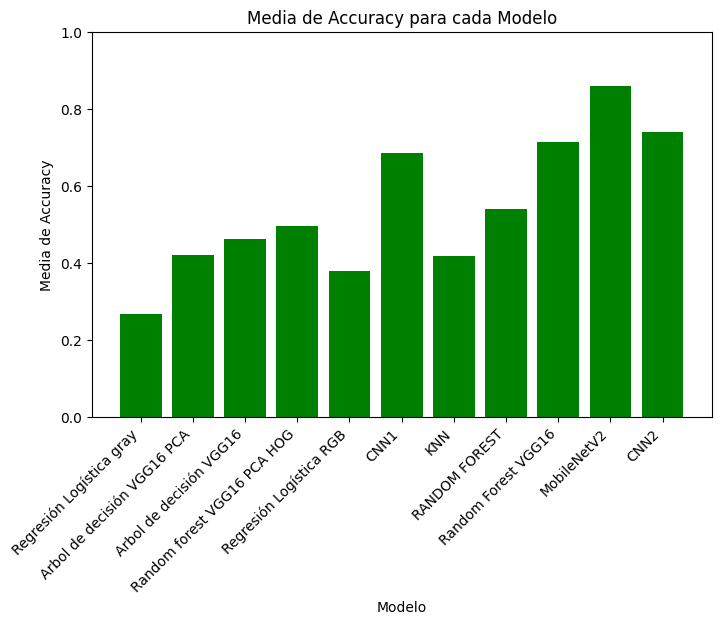

precision
Regresión Logística gray       0.237721
Arbol de decisión VGG16 PCA    0.412061
Arbol de decisión VGG16        0.458119
Random forest VGG16 PCA HOG    0.503782
Regresión Logística RGB        0.377517
CNN1                           0.700000
KNN                            0.435028
RANDOM FOREST                  0.546087
Random Forest VGG16            0.726763
MobileNetV2                    0.862121
Regresión Logística gray       0.261721
CNN2                           0.744876
Name: precision, dtype: float64


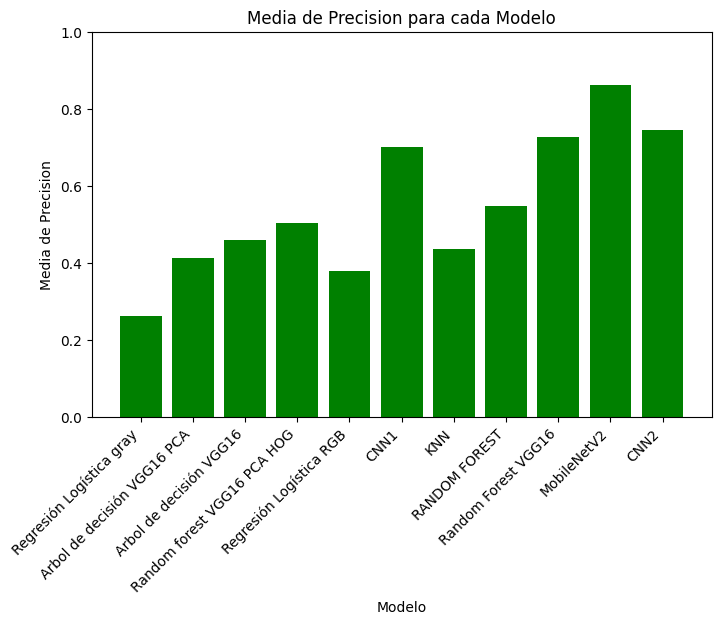

recall
Regresión Logística gray       0.236931
Arbol de decisión VGG16 PCA    0.412584
Arbol de decisión VGG16        0.451168
Random forest VGG16 PCA HOG    0.475645
Regresión Logística RGB        0.370069
CNN1                           0.713077
KNN                            0.435433
RANDOM FOREST                  0.528290
Random Forest VGG16            0.697247
MobileNetV2                    0.860000
Regresión Logística gray       0.259344
CNN2                           0.738559
Name: recall, dtype: float64


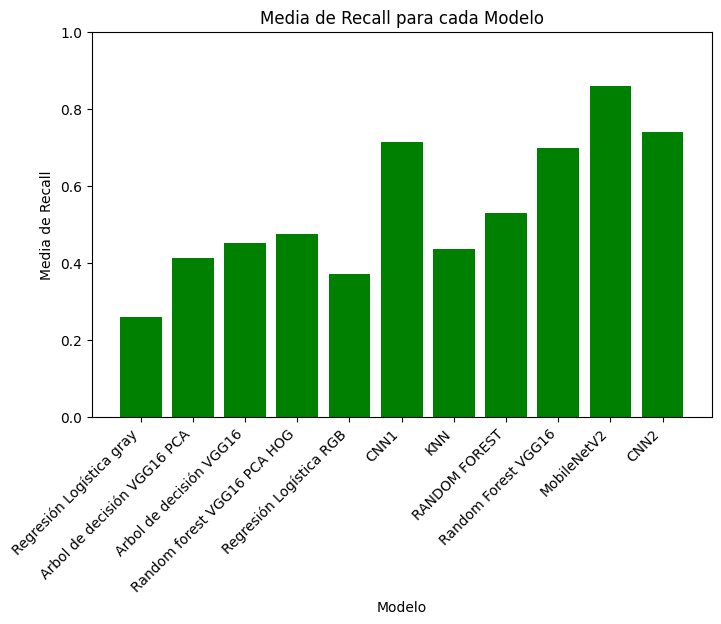

f1
Regresión Logística gray       0.234413
Arbol de decisión VGG16 PCA    0.411376
Arbol de decisión VGG16        0.451107
Random forest VGG16 PCA HOG    0.476544
Regresión Logística RGB        0.370564
CNN1                           0.700000
KNN                            0.420852
RANDOM FOREST                  0.529463
Random Forest VGG16            0.701317
MobileNetV2                    0.854834
Regresión Logística gray       0.257414
CNN2                           0.734516
Name: f1, dtype: float64


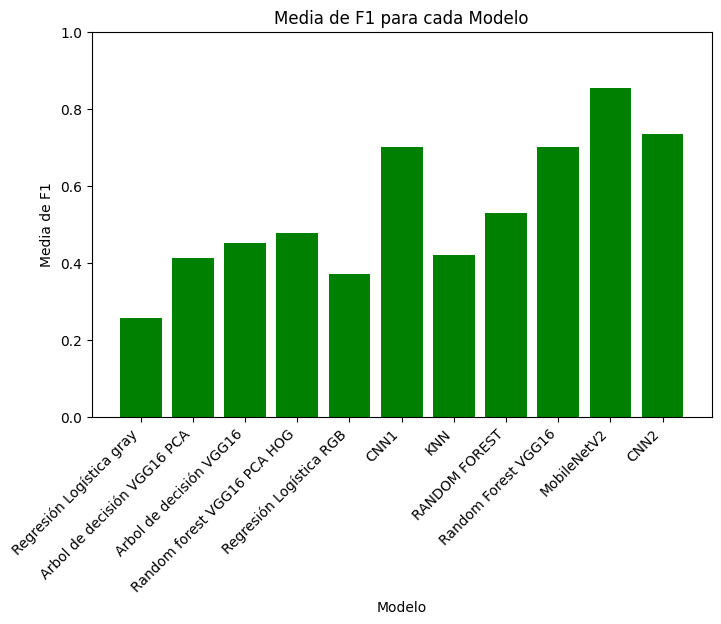

roc_auc
Regresión Logística gray       0.536279
Arbol de decisión VGG16 PCA    0.633404
Arbol de decisión VGG16        0.686157
Random forest VGG16 PCA HOG    0.773438
Regresión Logística RGB        0.679130
CNN1                           0.922000
KNN                            0.728536
RANDOM FOREST                  0.818893
Random Forest VGG16            0.915602
MobileNetV2                    0.956000
Regresión Logística gray       0.551579
CNN2                           0.936936
Name: roc_auc, dtype: float64


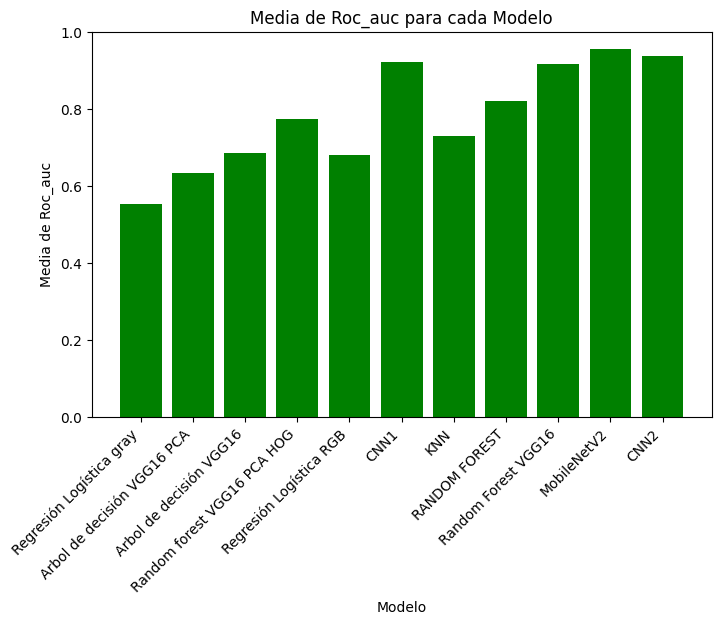

In [18]:
import pandas as pd
def graficar_metrics_desde_excel(file_path):
    # Leer el archivo Excel
    df = pd.read_excel(file_path, index_col=0)

    if not all(col in df.columns for col in scoring.keys()):
        raise ValueError(f"El archivo debe contener las siguientes columnas: {scoring.keys()}")

    # Extraer los modelos (que están en el índice)
    modelos = df.index
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']


    # Graficar la media de cada métrica para cada modelo
    for metric in metrics:
        plt.figure(figsize=(8, 5))
        plt.bar(modelos, df[metric], color='g')
        plt.title(f'Media de {metric.capitalize()} para cada Modelo')
        print(metric)
        print(df[metric])
        plt.xlabel('Modelo')
        plt.ylabel(f'Media de {metric.capitalize()}')
        plt.ylim([0, 1])  # Asegurarse de que el rango de la métrica esté entre 0 y 1
        plt.xticks(rotation=45, ha='right')
        plt.show()


graficar_metrics_desde_excel('results_cv.xlsx')


In [2]:
save_excel_cv(scoresLR_rgb, "Regresión Logística RGB")

NameError: name 'scoresLR_rgb' is not defined

In [64]:
## si es regresión logística gray ##
modelLR_gray, scoresLR_gray = regresion_logistica(X_train_gray, y_train_encoded)


In [ ]:
scoresLR_gray

[0 2 1 4 3 4 0 2 0 3 1 4 2 1 4 2 3 0 1 4 0 4 3 2 1 1 0 1 3 1 4 1 1 4 4 1 0
 1 3 0 4 0 1 2 2 1 4 3 4 3]


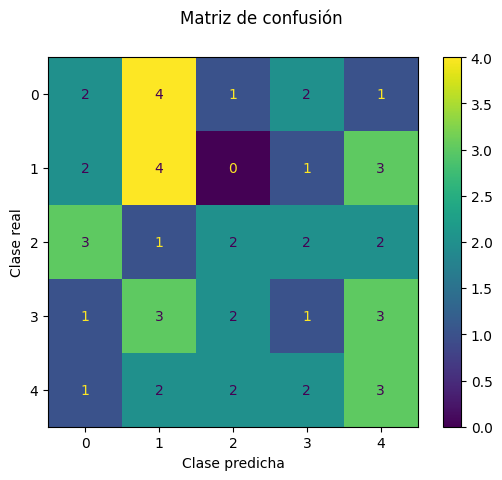

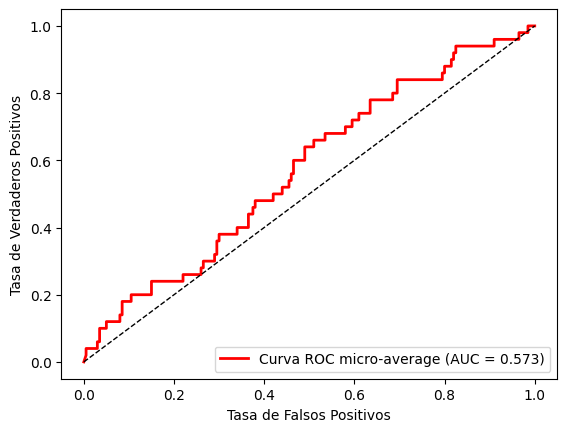

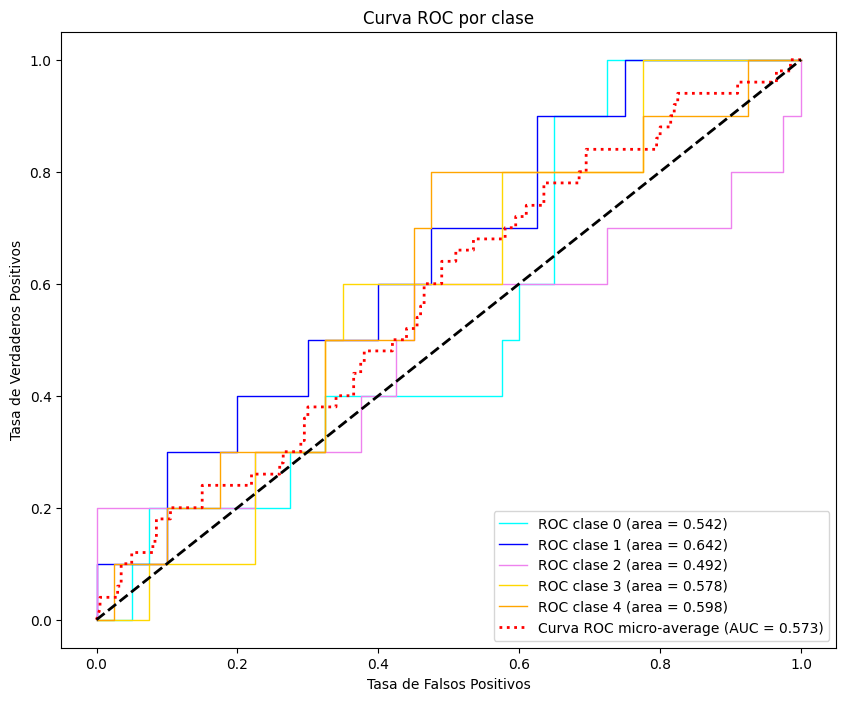

In [66]:
evaluar_rendimiento(modelLR_gray, X_test_gray, y_test_encoded, "Regresión Logística GRAY", None)

In [4]:
## si es regresión logística gray ##
modelLR_gray, scoresLR_gray = regresion_logistica(X_train_gray, y_train_encoded)
save_excel_cv(scoresLR_gray, "Regresión Logística gray")


In [5]:
## si es CNN1 ##
model1 = cnn1()
model1.summary()

history.append(model1.fit(X_train_rgb_64, y_train_encoded,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_rgb_64, y_test_encoded)))

history.history

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,877 (93.27 KB)

 Trainable params: 23,877 (93.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.2378 - loss: 1.5952 - val_accuracy: 0.3200 - val_loss: 1.5676
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.3248 - loss: 1.5003 - val_accuracy: 0.3400 - val_loss: 1.4344
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.3764 - loss: 1.4046 - val_accuracy: 0.4200 - val_loss: 1.4000
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4146 - loss: 1.3258 - val_accuracy: 0.4400 - val_loss: 1.2790
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.4341 - loss: 1.2942 - val_accuracy: 0.4600 - val_loss: 1.2457
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.4544 - loss: 1.2435 - val_accuracy: 0.4600 - val_loss: 1.2347
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.4742 - loss: 1.2359 - val_accuracy: 0.5000 - val_loss: 1.2060
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.4787 - loss: 1.2377 - val_accu

In [6]:
## si es CNN2 ##    
model2 = cnn2()
model2.summary()

history.append(model2.fit(X_train_rgb_64, y_train_encoded,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_test_rgb_64, y_test_encoded)))

history.history

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,437 (275.14 KB)

 Trainable params: 70,245 (274.39 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 531ms/step - accuracy: 0.4210 - loss: 1.4324 - val_accuracy: 0.2000 - val_loss: 1.7579
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 528ms/step - accuracy: 0.5943 - loss: 1.0571 - val_accuracy: 0.3600 - val_loss: 1.4836
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 526ms/step - accuracy: 0.6169 - loss: 0.9883 - val_accuracy: 0.2800 - val_loss: 1.4910
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 527ms/step - accuracy: 0.6574 - loss: 0.9008 - val_accuracy: 0.2600 - val_loss: 1.6217
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 522ms/step - accuracy: 0.6649 - loss: 0.8755 - val_accuracy: 0.2200 - val_loss: 1.6345
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 525ms/step - accuracy: 0.6883 - loss: 0.8125 - val_accuracy: 0.2600 - val_loss: 1.6314
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 527ms/step - accuracy: 0.6948 - loss: 0.8044 - val_accuracy: 0.2600 - val_loss: 1.6860
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 524ms/step - accuracy: 0.7185 - loss: 0.7533 - 

In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

def cnn1():
    model = models.Sequential()
    model.add(keras.Input(shape=(64, 64, 3)))  # Nueva dimensión de entrada

    # Primera capa convolucional
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Segunda capa convolucional
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Global Average Pooling para reducir dimensionalidad
    model.add(layers.GlobalAveragePooling2D())

    # Capa densa
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout para evitar el sobreajuste

    # Capa de salida con 5 clases
    model.add(layers.Dense(5, activation='softmax'))

    # Compilación del modelo
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

def cnn2():
    model = models.Sequential()
    model.add(keras.Input(shape=(64, 64, 3)))  # Nueva dimensión de entrada

    # Bloque 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # Bloque 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # Global Average Pooling en lugar de Flatten
    model.add(layers.GlobalAveragePooling2D())

    # Capa densa
    model.add(layers.Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dropout(0.2))

    # Capa de salida con Softmax
    model.add(layers.Dense(5, activation='softmax'))

    # Compilación del modelo
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

In [69]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Definir el número de folds
CV = 5
kf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=42)


# Para almacenar las métricas de cada fold
scores = {
    "precision_macro": [],
    "recall_macro": [],
    "precision_micro": [],
    "recall_micro": [],
    "f1_macro": [],
    "accuracy": [],
    "roc_auc": []
}

for fold, (train_index, val_index) in enumerate(kf.split(X_train_rgb_64, y_train_encoded)):
    print(f"\nFold {fold + 1}/{CV}")

    # Dividir los datos en train y validación
    X_train_fold, X_val_fold = X_train_rgb_64[train_index], X_train_rgb_64[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Crear un nuevo modelo en cada fold
    modelCNN1 = cnn1()

    # Entrenar el modelo
    modelCNN1.fit(X_train_fold, y_train_fold,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(X_val_fold, y_val_fold),
              verbose=1)

    # Predecir en el conjunto de validación
    y_pred_probs = modelCNN1.predict(X_val_fold)  # Probabilidades
    y_pred = np.argmax(y_pred_probs, axis=1)  # Clases predichas

    # Calcular métricas
    scores["accuracy"].append(accuracy_score(y_val_fold, y_pred))
    scores["precision_macro"].append(precision_score(y_val_fold, y_pred, average="macro"))
    scores["recall_macro"].append(recall_score(y_val_fold, y_pred, average="macro"))
    scores["precision_micro"].append(precision_score(y_val_fold, y_pred, average="micro"))
    scores["recall_micro"].append(recall_score(y_val_fold, y_pred, average="micro"))
    scores["f1_macro"].append(f1_score(y_val_fold, y_pred, average="macro"))

    # Calcular ROC AUC (solo si es clasificación multiclase con one-hot encoding)
    try:
        roc_auc = roc_auc_score(y_val_fold, y_pred_probs, multi_class="ovr")
        scores["roc_auc"].append(roc_auc)
    except ValueError:
        scores["roc_auc"].append(None)

# Mostrar los resultados de cada fold
for metric, values in scores.items():
    print(f"\n{metric}: {values}")



Fold 1/5
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.2200 - loss: 1.6071 - val_accuracy: 0.4025 - val_loss: 1.5589
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.3037 - loss: 1.5425 - val_accuracy: 0.3997 - val_loss: 1.4294
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.3679 - loss: 1.4263 - val_accuracy: 0.4633 - val_loss: 1.3136
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.3952 - loss: 1.3428 - val_accuracy: 0.4845 - val_loss: 1.2632
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.4342 - loss: 1.2870 - val_accuracy: 0.5056 - val_loss: 1.2368
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.4295 - loss: 1.2873 - val_accuracy: 0.4732 - val_loss: 1.2038
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.4591 - loss: 1.2554 - val_accuracy: 0.4915 - val_loss: 1.1796
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.5260 - loss: 1.1900 

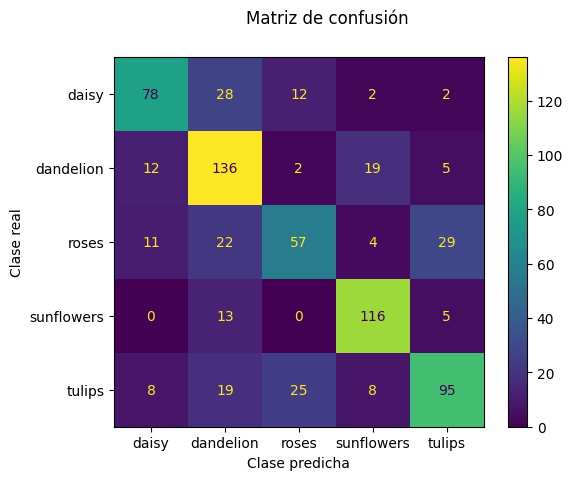

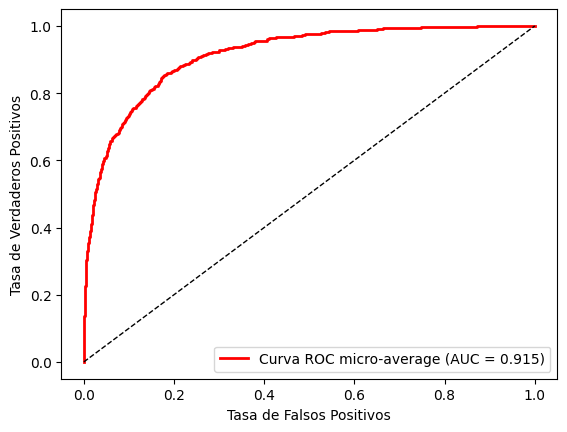

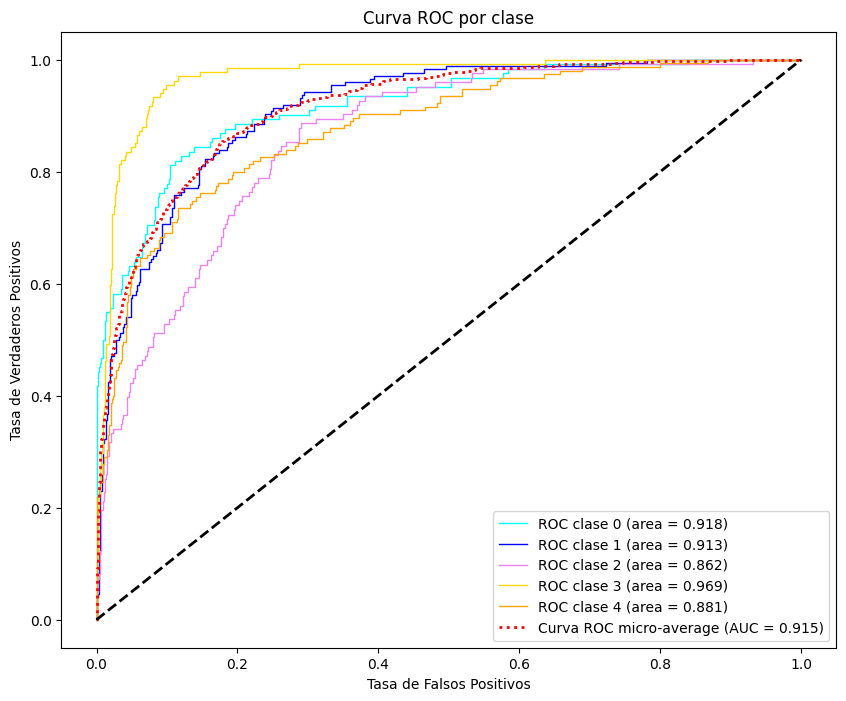

In [77]:
cmCNN1 = confusion_matrix(y_val_fold, y_pred)
y_val_bin = label_binarize(y_val_fold, classes=np.unique(y_train_encoded))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_val_bin.shape[1]):  # Para cada clase
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC micro (promedio de todas las clases)
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plot_rendimiento(
    cmCNN1,
    ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
    fpr_micro,
    tpr_micro,
    roc_auc_micro,
    fpr,
    tpr,
    roc_auc
)

In [104]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
# Definir el número de folds
CV = 5
kf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=42)


# Para almacenar las métricas de cada fold
scores = {
    "precision_macro": [],
    "recall_macro": [],
    "precision_micro": [],
    "recall_micro": [],
    "f1_macro": [],
    "accuracy": [],
    "roc_auc": []
}

for fold, (train_index, val_index) in enumerate(kf.split(X_train_rgb_64, y_train_encoded)):
    print(f"\nFold {fold + 1}/{CV}")

    # Dividir los datos en train y validación
    X_train_fold, X_val_fold = X_train_rgb_64[train_index], X_train_rgb_64[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Crear un nuevo modelo en cada fold
    model2 = cnn2()

    # Entrenar el modelo
    model2.fit(X_train_fold, y_train_fold,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(X_val_fold, y_val_fold),
              verbose=1)

    # Predecir en el conjunto de validación
    y_pred_probs = model2.predict(X_val_fold)  # Probabilidades
    y_pred = np.argmax(y_pred_probs, axis=1)  # Clases predichas

    # Calcular métricas
    scores["accuracy"].append(accuracy_score(y_val_fold, y_pred))
    scores["precision_macro"].append(precision_score(y_val_fold, y_pred, average="macro"))
    scores["recall_macro"].append(recall_score(y_val_fold, y_pred, average="macro"))
    scores["precision_micro"].append(precision_score(y_val_fold, y_pred, average="micro"))
    scores["recall_micro"].append(recall_score(y_val_fold, y_pred, average="micro"))
    scores["f1_macro"].append(f1_score(y_val_fold, y_pred, average="macro"))

    # Calcular ROC AUC (solo si es clasificación multiclase con one-hot encoding)
    try:
        roc_auc = roc_auc_score(y_val_fold, y_pred_probs, multi_class="ovr")
        scores["roc_auc"].append(roc_auc)
    except ValueError:
        scores["roc_auc"].append(None)

# Mostrar los resultados de cada fold
for metric, values in scores.items():
    print(f"\n{metric}: {values}")


Fold 1/5
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 701ms/step - accuracy: 0.3509 - loss: 1.6580 - val_accuracy: 0.1935 - val_loss: 1.6337
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 692ms/step - accuracy: 0.5619 - loss: 1.1379 - val_accuracy: 0.2895 - val_loss: 1.4979
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 759ms/step - accuracy: 0.5994 - loss: 1.0258 - val_accuracy: 0.2980 - val_loss: 1.5237
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 724ms/step - accuracy: 0.6262 - loss: 0.9953 - val_accuracy: 0.3249 - val_loss: 1.5446
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 750ms/step - accuracy: 0.6602 - loss: 0.9096 - val_accuracy: 0.2825 - val_loss: 1.6383
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 733ms/step - accuracy: 0.6764 - loss: 0.8755 - val_accuracy: 0.3107 - val_loss: 1.6268
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 736ms/step - accuracy: 0.6783 - loss: 0.8344 - val_accuracy: 0.2839 - val_loss: 1.7281
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 731ms/step - accuracy: 0.6692 - loss:

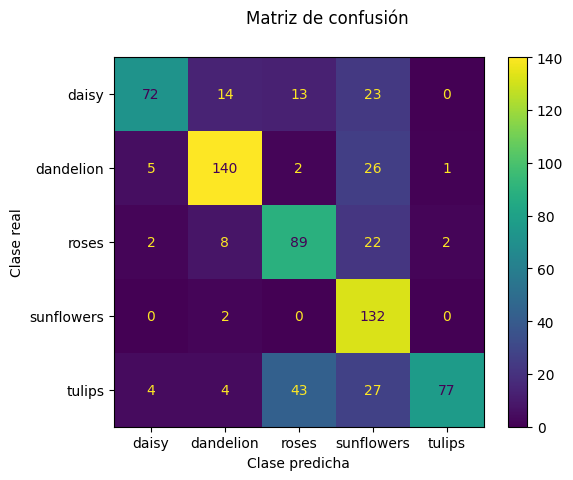

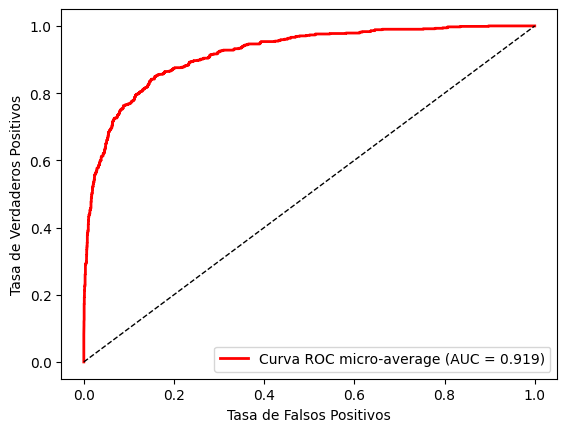

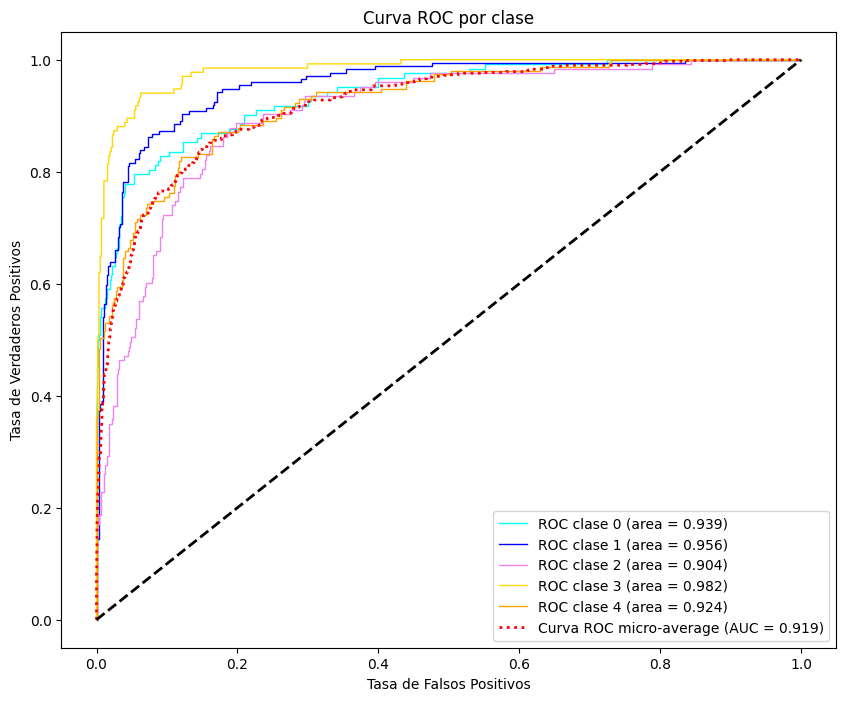

In [105]:
cmCNN2 = confusion_matrix(y_val_fold, y_pred)
y_val_bin = label_binarize(y_val_fold, classes=np.unique(y_train_encoded))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_val_bin.shape[1]):  # Para cada clase
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC micro (promedio de todas las clases)
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plot_rendimiento(
    cmCNN2,
    ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
    fpr_micro,
    tpr_micro,
    roc_auc_micro,
    fpr,
    tpr,
    roc_auc
)

In [ ]:

## KNN ## 
_, _, scoresKNN = knn(X_train_rgb, y_train_encoded, X_test_rgb)

save_excel_cv(scoresKNN, "KNN")

In [ ]:
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

from constants import CV, scoring
from utils import validacion

def knn_with_gridsearch(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded):
    # Aplanar las imágenes
    X_train_flattened = X_train_rgb.reshape(X_train_rgb.shape[0], -1)
    X_test_flattened = X_test_rgb.reshape(X_test_rgb.shape[0], -1)

    # Escalar las características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flattened)
    X_test_scaled = scaler.transform(X_test_flattened)

    # Definir el espacio de búsqueda de hiperparámetros
    param_grid = {
        'pca__n_components': [30, 50],
        'knn__n_neighbors': [3, 7]
    }

    # Crear un pipeline
    pipeline = Pipeline([
        ('pca', PCA()),
        ('knn', KNeighborsClassifier())
    ])

    # Aplicar GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=CV, scoring=scoring, refit='accuracy')
    grid_search.fit(X_train_scaled, y_train_encoded)

    print(f"Mejores parámetros: {grid_search.best_params_}")

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_
    best_pca = best_model.named_steps['pca']
    best_knn = best_model.named_steps['knn']

    results = pd.DataFrame(grid_search.cv_results_)[[
        'test_accuracy', 
        'test_precision', 
        'test_recall',
        'test_f1', 
        'test_roc_auc'
    ]]

    y_pred_knn = grid_search.predict(X_test_scaled)
    validacion(X_test_rgb, y_test_encoded, y_pred_knn)

    return best_knn, best_pca, results 
modelKNN, pcaKNN, scoresKNN = knn_with_gridsearch(X_train_rgb_64, y_train_encoded, X_test_rgb_64, y_test_encoded)

: 

In [25]:
datos = {
        'precision': [0.435028],
        'recall': [0.435433], 
        'f1': [0.420852 ], 
        'accuracy': [0.416206], 
        'roc_auc': [0.728536]
}
if os.path.exists("results_cv.xlsx"):
    results = pd.read_excel("results_cv.xlsx", index_col=0)
    df = pd.DataFrame(datos, index=["KNN"])
    results = pd.concat([results, df], ignore_index=False)
    results.to_excel("results_cv.xlsx")
else:
    results = pd.DataFrame(datos)
    results.index = ["KNN"]
    results.to_excel("results_cv.xlsx")
 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Aplanar las imágenes para el Árbol de Decisión
X_train_flat = X_train_rgb_64.reshape(X_train_rgb_64.shape[0], -1)  # De 4D a 2D

param_grid = {
    'max_depth': [10, 20, None],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en un nodo hoja
    'criterion': ['gini', 'entropy'],  # Función de división
}

# Búsqueda de los mejores parámetros utilizando GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5) #Validación cruzada
grid_search.fit(X_train_flat, y_train)

# Obtener el mejor modelo
model_tree = grid_search.best_estimator_
print(grid_search)


111/111 ━━━━━━━━━━━━━━━━━━━━ 599s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step
Resultados de Validación Cruzada:
accuracy: 0.5282
precision: 0.5194
recall: 0.5191
f1: 0.5189
roc_auc: 0.6960


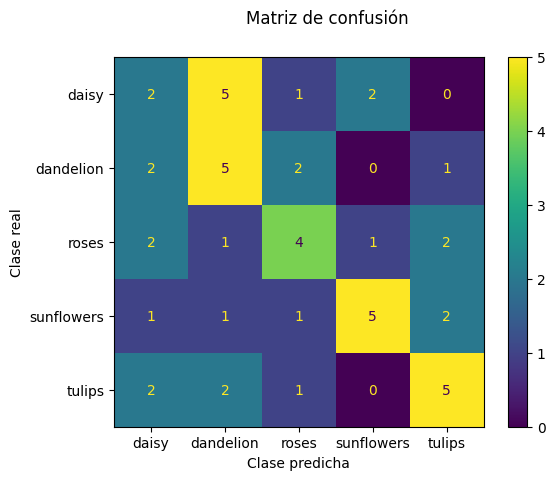

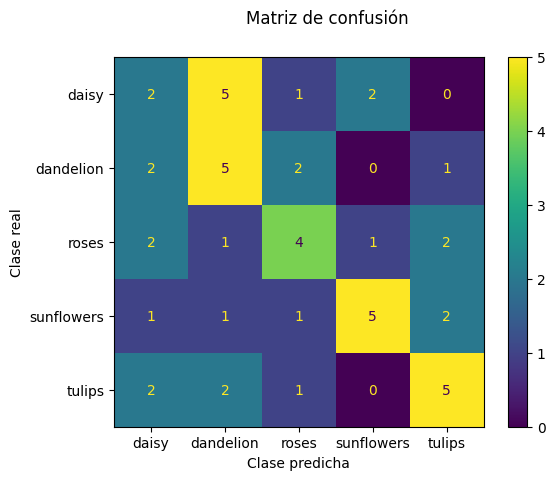

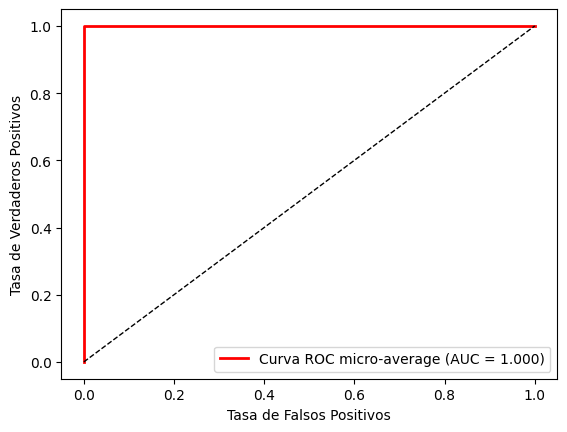

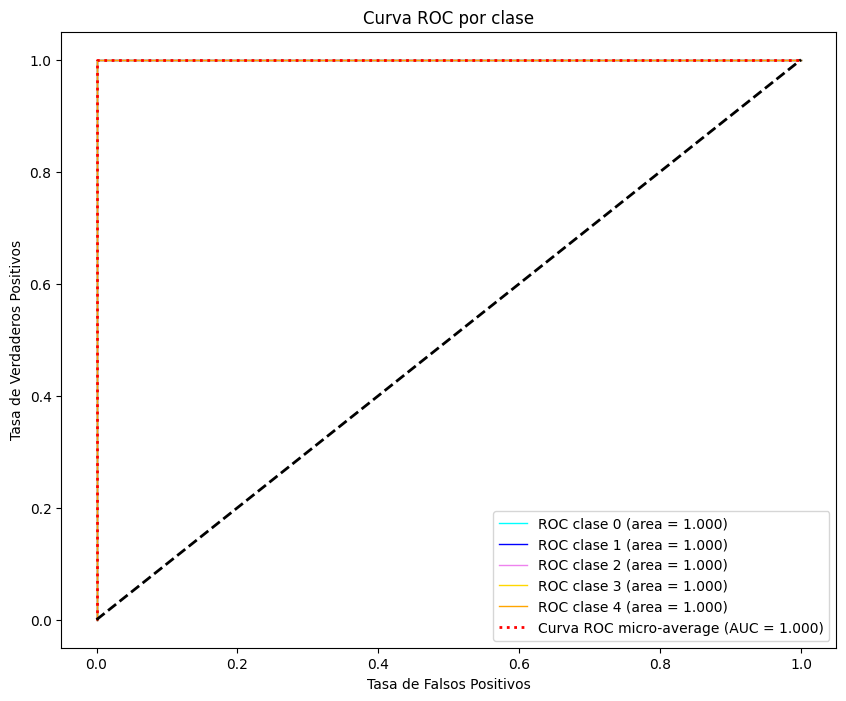

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utils import plot_rendimiento
def arbol_vgg16_pca(X_train, y_train, X_test, y_test_encoded, input_shape=(256,256,3), n_components=500):
    # Cargar VGG16 preentrenado SIN la capa superior
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256,256,3))
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    # Extraer características con VGG16
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    # Aplanar las características extraídas
    X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
    X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

    # Reducción de dimensionalidad con PCA
    pca = PCA(n_components=n_components, svd_solver='randomized')
    X_train_pca = pca.fit_transform(X_train_features_flat)
    X_test_pca = pca.transform(X_test_features_flat)

    # Validación cruzada con PCA y VGG16
    model_tree_pca = DecisionTreeClassifier(criterion="gini", max_depth=20, random_state=42)
    
    scores_tree_pca = cross_validate(model_tree_pca, X_train_pca, y_train, cv=5, scoring=scoring)
    #print(f"Precisión media de validación cruzada con VGG16 y PCA: {np.mean(scores_tree_pca):.4f}")
    print("Resultados de Validación Cruzada:")
    for metric in scoring:
        mean_score = np.mean(scores_tree_pca[f'test_{metric}'])
        print(f"{metric}: {mean_score:.4f}")
    # Entrenar el modelo con todo el conjunto de entrenamiento
    model_tree_pca.fit(X_train_pca, y_train)

    # Obtener las predicciones del modelo
    y_pred_prob = model_tree_pca.predict_proba(X_test_pca)

    # Si es clasificación multiclase
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test_encoded, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
    disp.plot()
    disp.figure_.suptitle("Matriz de confusión")
    disp.figure_.set_dpi(100)
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.show()

    y_val_bin = label_binarize(y_pred, classes=np.unique(y_train_encoded))

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(y_val_bin.shape[1]):  # Para cada clase
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC micro (promedio de todas las clases)
    fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    plot_rendimiento(
        cm,
        ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
        fpr_micro,
        tpr_micro,
        roc_auc_micro,
        fpr,
        tpr,
        roc_auc
    )
    
    return model_tree_pca, scores_tree_pca
modelTREE_VGG16, scoresTREE = arbol_vgg16_pca(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded)

In [ ]:
import pandas as pd
def graficar_metrics_desde_excel(file_path):
    # Leer el archivo Excel
    df = pd.read_excel(file_path, index_col=0)

    if not all(col in df.columns for col in scoring.keys()):
        raise ValueError(f"El archivo debe contener las siguientes columnas: {scoring.keys()}")

    # Extraer los modelos (que están en el índice)
    modelos = df.index
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']


    # Graficar la media de cada métrica para cada modelo
    for metric in metrics:
        plt.figure(figsize=(8, 5))
        plt.bar(modelos, df[metric], color='g')
        plt.title(f'Media de {metric.capitalize()} para cada Modelo')
        print(metric)
        print(df[metric])
        plt.xlabel('Modelo')
        plt.ylabel(f'Media de {metric.capitalize()}')
        plt.ylim([0, 1])  # Asegurarse de que el rango de la métrica esté entre 0 y 1
        plt.xticks(rotation=45, ha='right')
        plt.show()


graficar_metrics_desde_excel('results_cv.xlsx')


In [ ]:
modelTREE_VGG16_PCA = arbol_vgg16_pca(X_train_rgb_64, y_train_encoded)
# Evaluar el modelo con las funciones definidas previamente
evaluar_rendimiento(modelTREE_VGG16_PCA, X_test_rgb_64, y_test, "Árbol de Decisión VGG16 PCA")

In [40]:
num_classes = len(np.unique(y_train_encoded))  # Asegurar que tenemos el número correcto de clases
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes)

# Llamada a la función de entrenamiento
model_1 = train_mobilenetv2_model(X_train_rgb, y_train_onehot, X_test_rgb, y_test_onehot, epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.5, learning_rate=0.001)
#model_2 = train_mobilenetv2_model(X_train_rgb_64, y_train_onehot, X_test_rgb_64, y_test_onehot, input_shape=(64, 64, 3), epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.5, learning_rate=0.001)
#model_3 = train_mobilenetv2_model(X_train_rgb_64, y_train_onehot, X_test_rgb_64, y_test_onehot, input_shape=(64, 64, 3),epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.5, learning_rate=0.0001)
#model_4 = train_mobilenetv2_model(X_train_rgb_64, y_train_onehot, X_test_rgb_64, y_test_onehot, input_shape=(64, 64, 3),epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.3, learning_rate=0.001)

/Users/sabelayanezlopez/Documents/ROBOTICA E INFORMATICA INDUSTRIAL/trabajo VAI-AAI-PYTHON/modelos/MobileNetV2.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 97s 791ms/step - accuracy: 0.7068 - loss: 0.8083 - val_accuracy: 0.7800 - val_loss: 0.7742
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 99s 886ms/step - accuracy: 0.8945 - loss: 0.3013 - val_accuracy: 0.8000 - val_loss: 0.7343
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 104s 933ms/step - accuracy: 0.9265 - loss: 0.2104 - val_accuracy: 0.7600 - val_loss: 0.8343
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 100s 896ms/step - accuracy: 0.9329 - loss: 0.1858 - val_accuracy: 0.7400 - val_loss: 0.9679
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 100s 903ms/step - accuracy: 0.9348 - loss: 0.1706 - val_accuracy: 0.8200 - val_loss: 0.7211
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 794ms/step - accuracy: 0.9662 - loss: 0.1011 - val_accuracy: 0.8000 - val_loss: 0.8546
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 76s 680ms/step - accuracy: 0.9773 - loss: 0.0763 - val_accuracy: 0.8000 - val_loss: 0.9756
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 76s 687ms/step - accuracy: 0.9789 - loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


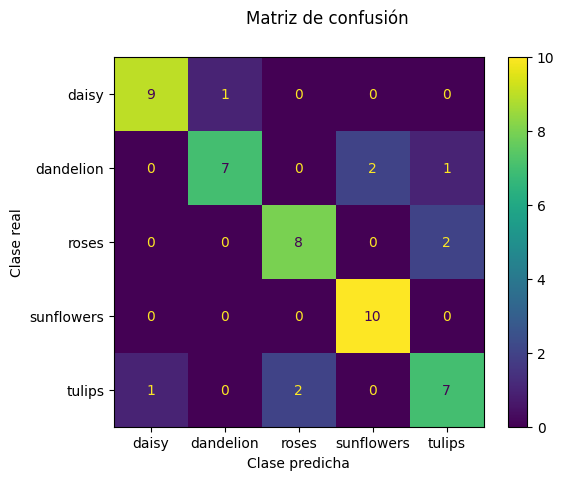

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Obtener las predicciones del modelo
y_pred_prob = model_1.predict(X_test_rgb)  # Probabilidades de las clases
y_pred = (y_pred_prob > 0.5).astype(int)  # Convertir las probabilidades en etiquetas de clase (binario)

# Si es clasificación multiclase
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_encoded, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
disp.plot()
disp.figure_.suptitle("Matriz de confusión")
disp.figure_.set_dpi(100)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.show()


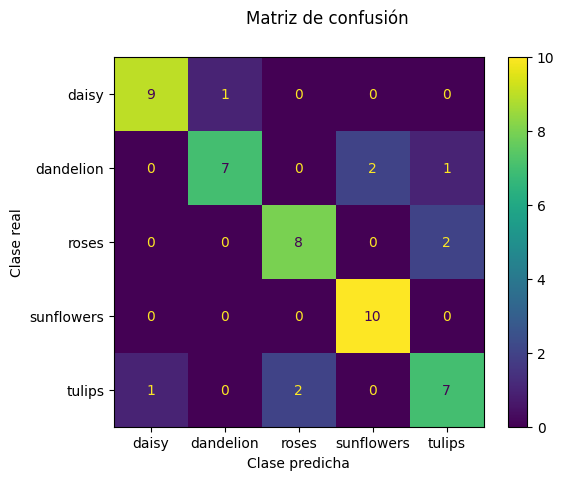

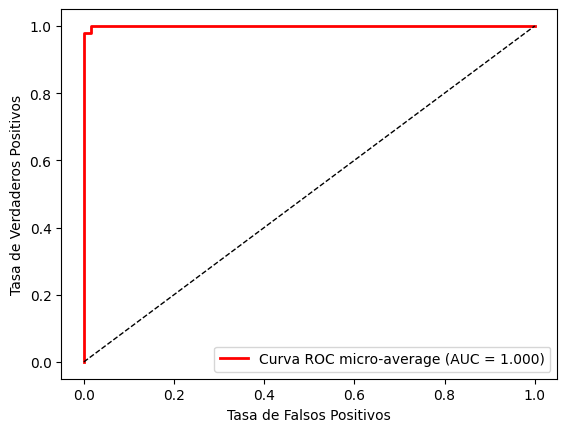

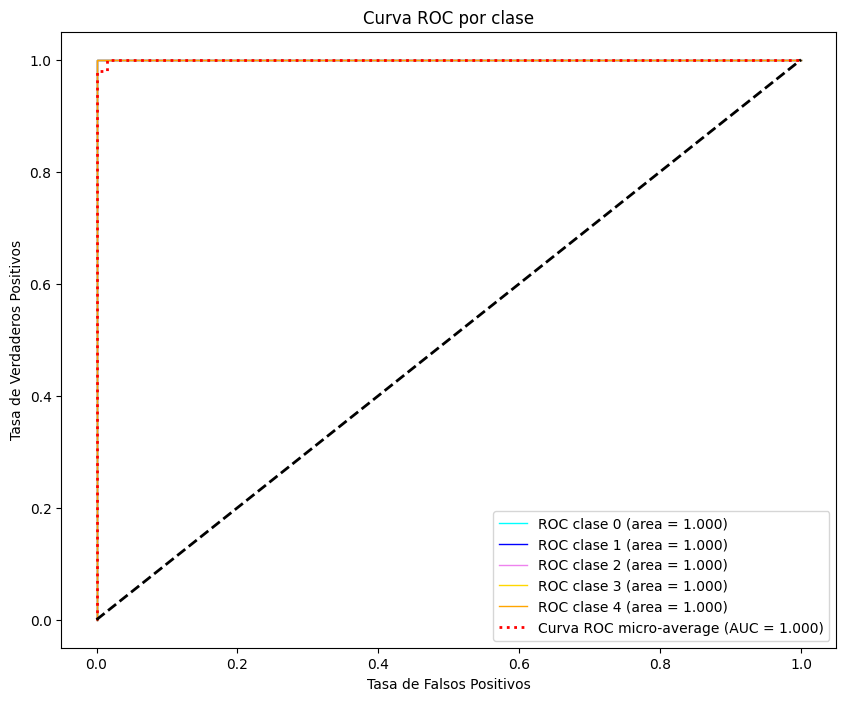

In [44]:
y_val_bin = label_binarize(y_pred, classes=np.unique(y_train_encoded))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_val_bin.shape[1]):  # Para cada clase
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC micro (promedio de todas las clases)
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plot_rendimiento(
    cm,
    ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
    fpr_micro,
    tpr_micro,
    roc_auc_micro,
    fpr,
    tpr,
    roc_auc
)


In [44]:
def evaluate_mobilenetv2_model(model, X_test, y_test):
    # Hacer predicciones
    y_pred_prob = model.predict(X_test)  # Predicciones de probabilidades
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convertir las probabilidades en clases

    # Convertir las etiquetas de prueba (y_test) a clases (si es one-hot encoding)
    y_test_class = np.argmax(y_test, axis=1)  # Asegúrate de que y_test esté en formato one-hot

    # Calcular Accuracy
    accuracy = accuracy_score(y_test_class, y_pred)
    
    # Calcular Precision
    precision = precision_score(y_test_class, y_pred, average='macro', zero_division=0)
    
    # Calcular Recall
    recall = recall_score(y_test_class, y_pred, average='macro', zero_division=0)
    
    # Calcular F1 Score
    f1 = f1_score(y_test_class, y_pred, average='macro', zero_division=0)
    
    # Calcular ROC AUC Score (solo para clasificación binaria o multiclasificación)
    # Si es clasificación binaria, usar average='macro', para multiclase 'ovr' (One-vs-Rest)
    if y_test_class.shape[0] > 1:
        roc_auc = roc_auc_score(y_test_class, y_pred_prob, multi_class='ovr', average='macro')
    else:
        roc_auc = roc_auc_score(y_test_class, y_pred_prob[:, 1])  # Para clasificación binaria

    # Mostrar las métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    datos = {
        'test_precision': [precision],
        'test_recall': [recall], 
        'test_f1': [f1], 
        'test_accuracy': [accuracy], 
        'test_roc_auc': [roc_auc]
    }

    save_excel_cv(datos, "MobileNetV2")
# Suponiendo que ya tienes el modelo entrenado y los datos de prueba listos:
evaluate_mobilenetv2_model(model_1, X_test_rgb, y_test_onehot)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
Accuracy: 0.8600
Precision: 0.8621
Recall: 0.8600
F1 Score: 0.8548
ROC AUC: 0.9560


In [1]:
modelRF, scoresRF = random_forest(X_train_rgb_64, y_train, X_test_rgb_64)


NameError: name 'random_forest' is not defined

In [28]:
save_excel_cv(scoresRF, "RANDOM FOREST")

In [ ]:
modelRF

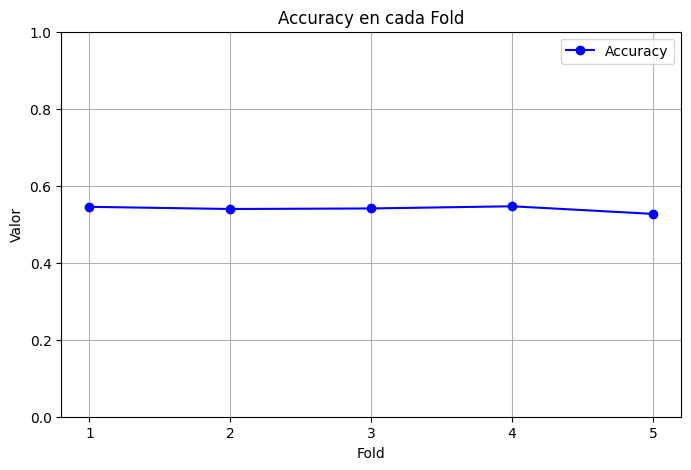

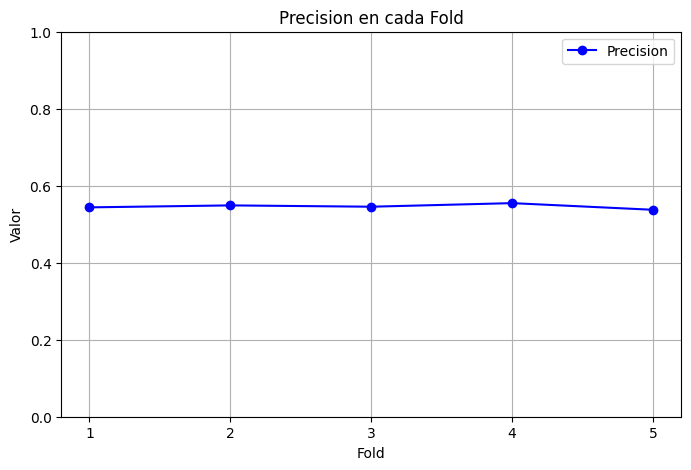

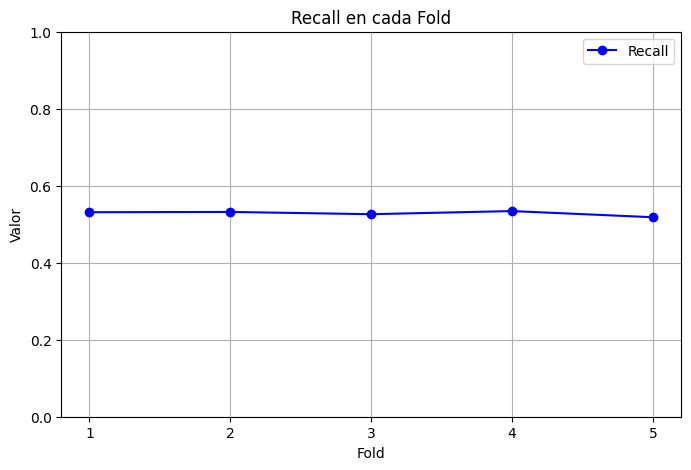

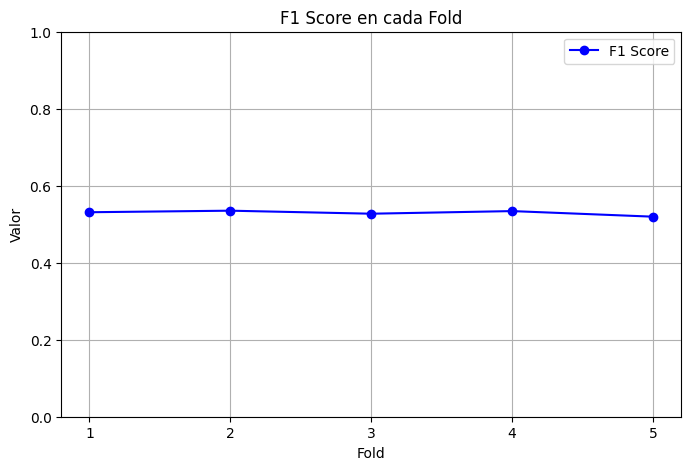

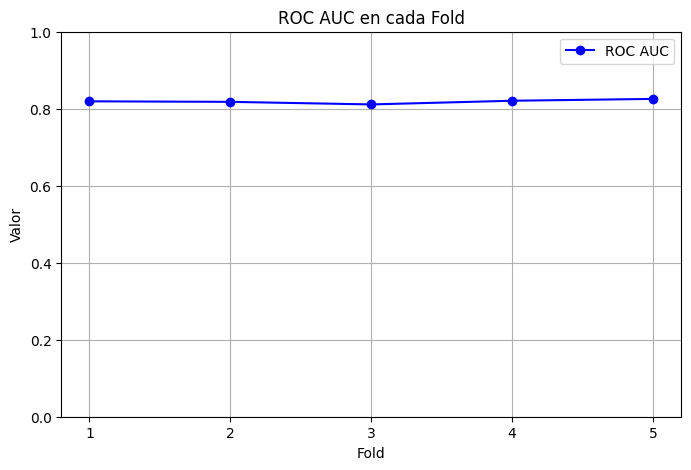

In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Extraer las métricas del diccionario 'scoresLR'
accuracy = scoresRF['test_accuracy']
precision = scoresRF['test_precision']
recall = scoresRF['test_recall']
f1 = scoresRF['test_f1']
roc_auc = scoresRF['test_roc_auc']

# Definir las métricas y sus nombres
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
}


for metric_name, metric_values in metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(metric_values) + 1), metric_values, marker='o', color='b', label=metric_name)
    plt.title(f'{metric_name} en cada Fold')
    plt.xlabel('Fold')
    plt.ylabel('Valor')
    plt.xticks(np.arange(1, len(metric_values) + 1))
    plt.ylim([0, 1])  # Asegurar que todas las métricas estén en el rango de 0 a 1
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from utils import validacion
from constants import scoring, CV
import matplotlib.pyplot as plt
import random
import numpy as np

def random_forest(X_train, y_train_encoded, X_test, y_test_encoded):
    # Aplanar imágenes
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Crear y entrenar el modelo Random Forest
    modelRF = RandomForestClassifier(n_estimators=100, random_state=42)
    modelRF.fit(X_train_flat, y_train_encoded)

    # Hacer predicciones
    y_pred_rf = modelRF.predict(X_test_flat)

    # Validación cruzada
    scoresRF = cross_validate(modelRF, X_train_flat, y_train_encoded, cv=5, scoring='accuracy')

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test_encoded, y_pred_rf)
    
    # Calcular la curva ROC AUC
    # Aseguramos que las etiquetas sean binarias (si es clasificación binaria)
    y_test_bin = label_binarize(y_test_encoded, classes=[0, 1])
    y_pred_prob = modelRF.predict_proba(X_test_flat)[:, 1]  # Probabilidades de la clase positiva (1)

    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.colorbar()
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    tick_marks = np.arange(len([0, 1]))
    plt.xticks(tick_marks, [0, 1])
    plt.yticks(tick_marks, [0, 1])
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.show()

    # Graficar la curva ROC AUC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal aleatoria
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC AUC')
    plt.legend(loc='lower right')
    plt.show()


    return modelRF, scoresRF 

def rforest_vgg16_pca(X_train, y_train_encoded, X_test, input_shape=(256, 256, 3), n_components=500):
    
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    # Extraer características con VGG16
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    # Aplanar las características extraídas
    X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
    X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)
    
    pca = PCA(n_components=500, svd_solver='randomized')  # Elegimos 200 características más relevantes
    X_train_pca = pca.fit_transform(X_train_features_flat)
    X_test_pca = pca.transform(X_test_features_flat)

    modelRF = RandomForestClassifier(
        n_estimators=200,  # Más árboles = mejor generalización
        max_depth=30,  # Mayor profundidad
        min_samples_split=3,  # Menos datos necesarios para dividir
        min_samples_leaf=2,  # Evita ramas muy pequeñas
        random_state=42
    )

    # Validación cruzada
    scoresRF = cross_validate(modelRF, X_train_pca, y_train_encoded, cv=CV, scoring=scoring)

    modelRF.fit(X_train_pca, y_train_encoded)
    
    # Precisión con VGG16 + PCA
    return modelRF, scoresRF

def extract_hog_features(images):

    hog_features = []
    for img in images:
        feature = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(feature)

    return np.array(hog_features)

def rforest_vgg16_pca_hog(X_train, y_train, X_test, X_train_gray, X_test_gray, input_shape=(256, 256), n_components=500):
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    # Extraer características con VGG16
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    # Aplanar las características extraídas
    X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
    X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)
    
    pca = PCA(n_components=500, svd_solver='randomized')  # Elegimos 200 características más relevantes
    X_train_pca = pca.fit_transform(X_train_features_flat)
    X_test_pca = pca.transform(X_test_features_flat)

    # Extraer características HOG
    X_train_hog = extract_hog_features(X_train_gray)
    X_test_hog = extract_hog_features(X_test_gray)
    # Normalizar características
    scaler = StandardScaler()
    X_train_hog_scaled = scaler.fit_transform(X_train_hog)
    X_test_hog_scaled = scaler.transform(X_test_hog)

    # Concatenar VGG16 + HOG
    X_train_combined = np.hstack((X_train_pca, X_train_hog_scaled))
    X_test_combined = np.hstack((X_test_pca, X_test_hog_scaled))

    # Entrenar Random Forest con características combinadas
    model_rf_combined = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
    
    cv_scores = cross_validate(model_rf_combined, X_train_combined, y_train, cv=CV, scoring=scoring)

    model_rf_combined.fit(X_train_combined, y_train)

    return model_rf_combined, cv_scores

modelRF, scoresRF = random_forest(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded)        


ValueError: multilabel-indicator format is not supported

In [86]:
modelRF_VGG16

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=200, random_state=42)

In [ ]:

evaluar_rendimiento(modelRF_VGG16, X_test_pca, y_test_encoded, "Random Forest VGG16", None)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


ValueError: X has 50 features, but RandomForestClassifier is expecting 500 features as input.

In [32]:
save_excel_cv(scoresRF_VGG16, "Random Forest VGG16")

In [18]:
from constants import excel_filename_cv
import pandas as pd
def save_excel_cv(scores): 
    datos = {
        'precision': [np.mean(scores['test_precision'])],
        'recall': [np.mean(scores['test_recall'])], 
        'f1': [np.mean(scores['test_f1'])], 
        'accuracy': [np.mean(scores['test_accuracy'])], 
        'roc_auc': [np.mean(scores['test_roc_auc'])]
    }
    if os.path.exists(excel_filename_cv):
        results = pd.read_excel(excel_filename_cv, index_col=0)
        df = pd.DataFrame(datos, index=['Random Forest VGG16 PCA'])
        results = pd.concat([results, df], ignore_index=False)
        results.to_excel(excel_filename_cv)

111/111 ━━━━━━━━━━━━━━━━━━━━ 687s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step


In [ ]:
model_rf_vgg, scores_rf_vgg = rforest_vgg16_pca(X_train_rgb_64, y_train_encoded, X_test_rgb_64)

In [85]:
model_rf_vgg_pca_hog, scores_rf_vgg_pca_hog = rforest_vgg16_pca_hog(X_train_rgb_64, y_train_encoded, X_test_rgb_64, X_train_gray, X_test_gray)

ValueError: `input_shape` must be a tuple of three integers.

In [ ]:
from skimage.feature import hog
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report
from Extractores_con_clasificador.ann_hog import ann_hog
from Extractores_con_clasificador.svm_hog import svm_hog
from sklearn.svm import SVC

def ann_hog(X_train_hog, y_train, X_test_hog, y_test, num_classes):
    # Convertir las etiquetas a one-hot encoding
    y_train_onehot = to_categorical(y_train, num_classes)
    y_test_onehot = to_categorical(y_test, num_classes)

    # Crear el modelo ANN
    ann_model = Sequential([
        Dense(512, activation='relu', input_dim=X_train_hog.shape[1]),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # num_classes = cantidad de clases
    ])

    # Compilar el modelo
    ann_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo ANN
    ann_model.fit(X_train_hog, y_train_onehot, epochs=5, batch_size=32, validation_data=(X_test_hog, y_test_onehot))

    # Obtener predicciones
    y_pred_ann = ann_model.predict(X_test_hog)
    y_pred_ann_classes = np.argmax(y_pred_ann, axis=1)

    # Calcular precisión
    accuracy_ann = accuracy_score(y_test, y_pred_ann_classes)
    print(f"Precisión ANN con HOG: {accuracy_ann:.2f}")

    # Generar reporte de clasificación
    print("\nReporte de ANN con HOG:")
    print(classification_report(y_test, y_pred_ann_classes))

    return ann_model

def svm_hog(X_train_hog, y_train, X_test_hog, y_test):
    # Crear y entrenar el clasificador SVM
    svm_model = SVC(kernel="linear", random_state=42)
    svm_model.fit(X_train_hog, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred_svm = svm_model.predict(X_test_hog)

    # Evaluar precisión
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    print(f"Precisión SVM con HOG: {accuracy_svm:.2f}")

    # Generar reporte de clasificación
    print("\nReporte de SVM con HOG:")
    print(classification_report(y_test, y_pred_svm))

    return svm_model

def extract_hog_features(images):
    hog_features = []
    for img in images:
        feature = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(feature)
    return np.array(hog_features)

def main_hog(X_train, X_test, y_train, y_test, num_classes):
    # Extraer características HOG
    X_train_hog = extract_hog_features(X_train)
    X_test_hog = extract_hog_features(X_test)

    # Entrenar y evaluar ANN con características HOG
    print("Entrenando y evaluando ANN con características HOG...")
    ann_model = ann_hog(X_train_hog, y_train, X_test_hog, y_test, num_classes)

    # Entrenar y evaluar SVM con características HOG
    print("\nEntrenando y evaluando SVM con características HOG...")
    svm_model = svm_hog(X_train_hog, y_train, X_test_hog, y_test)

    return ann_model, svm_model

In [ ]:
print(type(hog))  # Debe imprimir: <class 'function'>


<class 'function'>


In [ ]:
num_classes = len(np.unique(y_train))  # Suponiendo que y_train contiene las etiquetas
main_hog(X_train_gray, X_test_gray, y_train_encoded, y_test_encoded, num_classes)

Entrenando y evaluando ANN con características HOG...


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2620 - loss: 2.2188 - val_accuracy: 0.3400 - val_loss: 1.5087
Epoch 2/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.3629 - loss: 1.4627 - val_accuracy: 0.3200 - val_loss: 1.5507
Epoch 3/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3891 - loss: 1.4153 - val_accuracy: 0.2600 - val_loss: 1.5111
Epoch 4/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.4106 - loss: 1.3725 - val_accuracy: 0.3600 - val_loss: 1.4657
Epoch 5/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4087 - loss: 1.3856 - val_accuracy: 0.3400 - val_loss: 1.4608
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Precisión ANN con HOG: 0.34

Reporte de ANN con HOG:
              precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.33      0.40      0.36        10
           2       0.31      0.40      0.35        10
           3       0.33      0.10      0.15        1

(<Sequential name=sequential, built=True>,
 SVC(kernel='linear', random_state=42))

In [ ]:
## diagrama de cajas validación cru
data = [scoresLR_rgb['test_accuracy'], scoresLR_gray['test_accuracy'], scoresKNN['test_accuracy']]
_, ax = plt.subplots()
ax.set_title('Modelos')
ax.boxplot(data,labels=['LR_RGB','LR_GRAY','KNN'])

NameError: name 'scoresLR_rgb' is not defined

/var/folders/2k/r25tybc17h30wxjr2s82y9dh0000gn/T/ipykernel_55461/3652990565.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data,labels=['LR_rgb', 'ARBOL_VGG', 'ARBOL_VGG_PCA', 'RF', 'RF_VGG16'])


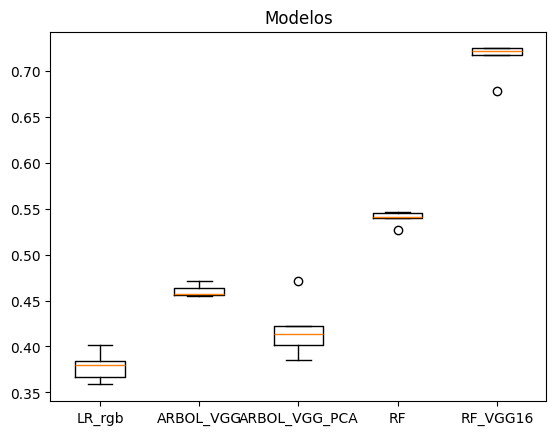

In [101]:
from constants import excel_filename_cv
def plot_accuracy_from_excel(excel_filename_cv):
    # Leer el archivo Excel
    df = pd.read_excel(excel_filename_cv, index_col=0)
    
    # Los valores de precisión están en la columna 'accuracy' y las etiquetas en el índice
   
    data = [scoresLR_rgb['test_accuracy'], 
            scores_arbol_VGG['test_accuracy'], scores_arbol_VGG_PCA['test_accuracy'],
            scoresRF['test_accuracy'], scoresRF_VGG16['test_accuracy']]
            
    fig7, ax = plt.subplots()
    ax.set_title('Modelos')
    ax.boxplot(data,labels=['LR_rgb', 'ARBOL_VGG', 'ARBOL_VGG_PCA', 'RF', 'RF_VGG16'])

# Llamar a la función con el archivo Excel
plot_accuracy_from_excel(excel_filename_cv)

